---
title: "predicting implied volatility in option trading using NN(i only used LSTM)"
format:
  html:
    embed-resources: true
---

## ✅ Step 1: Import packages and set seeds

In [ ]:
# Essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Machine learning tools
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Deep learning backend
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Try enabling mixed precision if supported
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
except ImportError:
    pass

## ✅ Step 2: Load and preprocess raw option data

In [ ]:
def load_raw(option_path: Path) -> pd.DataFrame:
    """Load the option dataset and perform basic preprocessing."""
    df = pd.read_csv(option_path, parse_dates=["date", "exdate"])

    # Calculate mid prices and days to expiration
    df["mid_price"] = (df["best_bid"] + df["best_offer"]) / 2
    df["days_to_expiry"] = (df["exdate"] - df["date"]).dt.days
    df["cp_flag_encoded"] = df["cp_flag"].map({"C": 1, "P": 0})
    df["strike_price"] = df["strike_price"] / 1000  # Strike is stored as *1000

    # Drop rows missing any important fields
    needed = [
        "strike_price", "cp_flag_encoded", "days_to_expiry",
        "impl_volatility", "delta", "gamma", "vega", "theta", "mid_price"
    ]
    df = df.dropna(subset=needed).reset_index(drop=True)
    return df


def build_feature_matrices(df: pd.DataFrame):
    """Build feature matrix (X), target (y), and grouping (dates)."""
    feature_cols = [
        "strike_price", "cp_flag_encoded", "days_to_expiry",
        "mid_price", "delta", "gamma", "vega", "theta"
    ]
    X = df[feature_cols].values
    y = df["impl_volatility"].values
    groups = df["date"].values

    # Standardize input features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))  # Reshape for RNN input
    return X_scaled, y, groups, scaler

## ✅ Step 3: Define lightweight neural network models

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2

def make_rnn(input_shape, units=32, l2_reg=1e-4, dropout_rate=0.2, rec_dropout=0.2):
    """
    SimpleRNN model for implied volatility prediction.
    Includes L2 regularization and dropout to help prevent overfitting.
    """
    model = Sequential([
        Input(shape=input_shape),
        SimpleRNN(
            units,
            activation="tanh",
            kernel_regularizer=l2(l2_reg),
            recurrent_regularizer=l2(l2_reg),
            recurrent_dropout=rec_dropout
        ),
        Dropout(dropout_rate),
        Dense(units // 2, activation="relu", kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate * 0.5),
        Dense(1, activation="linear")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
    return model

def make_lstm(input_shape, units=32, l2_reg=1e-4, dropout_rate=0.4, rec_dropout=0.25):
    """
    LSTM-based model for IV forecasting.
    Adds batch normalization after main layers to stabilize training.
    """
    from tensorflow.keras.layers import BatchNormalization

    model = Sequential([
        Input(shape=input_shape),
        LSTM(
            units,
            activation="tanh",
            kernel_regularizer=l2(l2_reg),
            recurrent_regularizer=l2(l2_reg),
            recurrent_dropout=rec_dropout
        ),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(16, activation="relu", kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate * 0.75),
        Dense(1, activation="linear")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
    return model

def make_gru(input_shape, units=32, l2_reg=1e-4, dropout_rate=0.3, rec_dropout=0.2):
    """
    GRU model optimized for small datasets.
    Uses L2 regularization and dropout for generalization.
    """
    model = Sequential([
        Input(shape=input_shape),
        GRU(
            units,
            activation="tanh",
            kernel_regularizer=l2(l2_reg),
            recurrent_regularizer=l2(l2_reg),
            recurrent_dropout=rec_dropout
        ),
        Dropout(dropout_rate),
        Dense(16, activation="relu", kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate * 0.5),
        Dense(1, activation="linear")
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
    return model

# Mapping model type to its builder
MODEL_FACTORY = {
    "rnn": make_rnn,
    "lstm": make_lstm,
    "gru": make_gru,
}

## ✅ Step 4: Train model with GroupKFold cross-validation

In [33]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def train_cv(X, y, groups, model_name: str, epochs: int, batch: int):
    """
    Train a model using 3‑fold GroupKFold cross‑validation with improved callbacks:
      - ModelCheckpoint to save best weights
      - EarlyStopping with tighter patience
      - ReduceLROnPlateau with more aggressive decay

    Returns:
      y_test_last : np.ndarray
        True targets from the last fold
      y_pred_last : np.ndarray
        Predictions from the last fold
      mse_scores  : list of float
        Mean Squared Error per fold
      r2_scores   : list of float
        R² score per fold
    """
    gkf = GroupKFold(n_splits=3)
    mse_scores, r2_scores = [], []
    y_test_last, y_pred_last = None, None

    for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups), start=1):
        print(f"\n—— Fold {fold} ——")

        # Split into this fold's train & test
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Instantiate model by name
        model = MODEL_FACTORY[model_name](input_shape=X.shape[1:])
        model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")

        # Improved callbacks
        callbacks = [
            # Save best model weights on validation loss
            ModelCheckpoint(
              filepath=f"{model_name}_best.keras",   # switch to Keras-native format
              monitor="val_loss",
              save_best_only=True,
              verbose=0
            ),
            # Early stop with shorter patience to avoid overfitting
            EarlyStopping(
                monitor="val_loss",
                patience=4,
                restore_best_weights=True,
                verbose=0
            ),
            # Reduce learning rate more aggressively when plateauing
            ReduceLROnPlateau(
                monitor="val_loss",
                factor=0.5,
                patience=2,
                min_lr=1e-6,
                verbose=0
            )
        ]

        # Fit model
        model.fit(
            X_train, y_train,
            validation_split=0.1,
            epochs=epochs,
            batch_size=batch,
            verbose=0,
            callbacks=callbacks
        )

        # Evaluate on this fold
        y_pred = model.predict(X_test, verbose=0).flatten()
        mse = mean_squared_error(y_test, y_pred)
        r2  = r2_score(y_test, y_pred)
        mse_scores.append(mse)
        r2_scores.append(r2)

        print(f"Fold {fold}: MSE={mse:.4e}  R²={r2:.4f}")

        # Save last‑fold outputs for diagnostics
        y_test_last, y_pred_last = y_test, y_pred

    # Summary metrics
    print("\n—— Cross‑validation summary ——")
    print("MSE :", np.round(mse_scores, 4))
    print("R²  :", np.round(r2_scores, 4))
    print(f"Avg MSE={np.mean(mse_scores):.4e}, Avg R²={np.mean(r2_scores):.4f}")

    return y_test_last, y_pred_last, mse_scores, r2_scores

## ✅ Step 5: Diagnostic plots (Prediction vs Actual, Residuals)

In [34]:
def quick_plots(y_true, y_pred, model_name):
    """Create scatter plot and residual histogram for model diagnostics."""
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Prediction vs Actual IV
    axes[0].scatter(y_true, y_pred, alpha=0.3, edgecolor="k", s=15)
    lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    axes[0].plot(lims, lims, "r--")
    axes[0].set_title(f"{model_name.upper()} — Predicted vs Actual")
    axes[0].set_xlabel("Actual IV")
    axes[0].set_ylabel("Predicted IV")

    # Residual distribution
    residuals = y_true - y_pred
    sns.histplot(residuals, bins=50, ax=axes[1], kde=True, color="skyblue")
    axes[1].set_title("Residual Distribution")
    axes[1].set_xlabel("Actual − Predicted")

    plt.tight_layout()
    plt.show()

## Manual configuration for notebook use


====================== Running RNN ======================

—— Fold 1 ——
Fold 1: MSE=1.2643e-03  R²=0.9610

—— Fold 2 ——
Fold 2: MSE=1.9825e-03  R²=0.9400

—— Fold 3 ——
Fold 3: MSE=2.8560e-03  R²=0.9188

—— Cross‑validation summary ——
MSE : [0.0013 0.002  0.0029]
R²  : [0.961  0.94   0.9188]
Avg MSE=2.0343e-03, Avg R²=0.9399


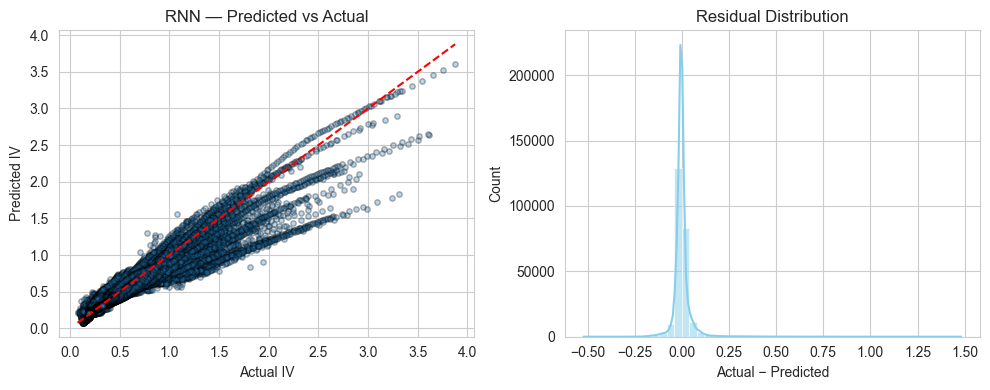


====================== Running LSTM ======================

—— Fold 1 ——
Fold 1: MSE=2.9593e-03  R²=0.9086

—— Fold 2 ——
Fold 2: MSE=1.7697e-03  R²=0.9464

—— Fold 3 ——
Fold 3: MSE=1.8083e-03  R²=0.9486

—— Cross‑validation summary ——
MSE : [0.003  0.0018 0.0018]
R²  : [0.9086 0.9464 0.9486]
Avg MSE=2.1791e-03, Avg R²=0.9345


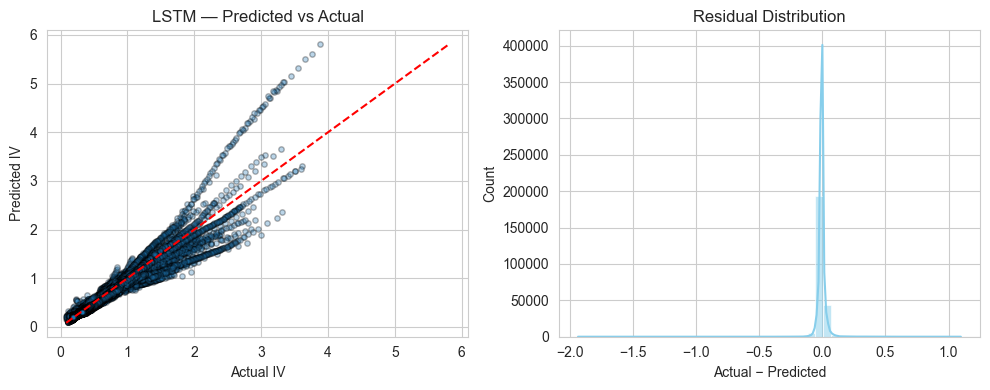


====================== Running GRU ======================

—— Fold 1 ——
Fold 1: MSE=1.1388e-03  R²=0.9648

—— Fold 2 ——
Fold 2: MSE=1.6896e-03  R²=0.9489

—— Fold 3 ——
Fold 3: MSE=2.9250e-03  R²=0.9168

—— Cross‑validation summary ——
MSE : [0.0011 0.0017 0.0029]
R²  : [0.9648 0.9489 0.9168]
Avg MSE=1.9178e-03, Avg R²=0.9435


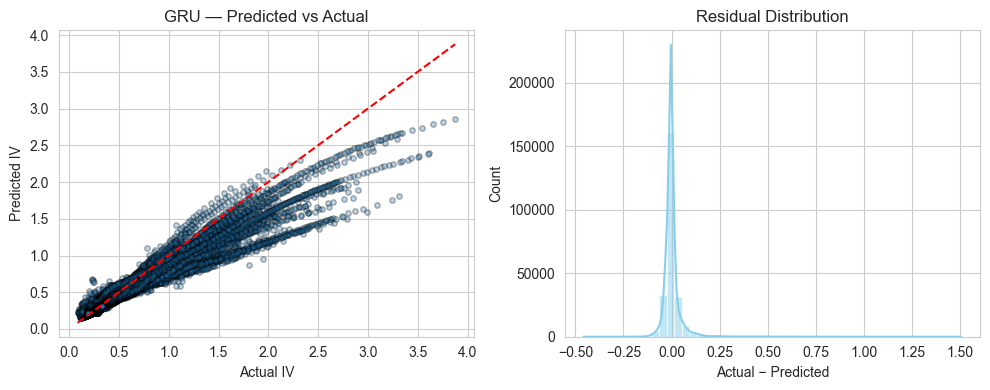

In [ ]:
# Manual config for quick notebook runs (no command-line parsing)
data_path = "./dataset/ndx_option_raw.csv"

MODEL_FACTORY = {
    "rnn": make_rnn,
    "lstm": make_lstm,
    "gru": make_gru
}

# Lower settings to speed up training on M1 machines
epochs = 20
batch_size = 64

# Load and prepare the data
df = load_raw(Path(data_path))
X, y, groups, _ = build_feature_matrices(df)

# Container to track results for each model
results = {}

# Train and evaluate RNN, LSTM, and GRU
for model_name in ["rnn", "lstm", "gru"]:
    print(f"\n====================== {model_name.upper()} Training ======================")

    y_test, y_pred, mse_list, r2_list = train_cv(
        X, y, groups, model_name, epochs, batch_size
    )

    # Save results for later comparison
    results[model_name.upper()] = {
        "y_true": y_test,
        "y_pred": y_pred,
        "mse": mse_list,
        "r2": r2_list
    }

    # Quick plots for visual checking
    quick_plots(y_test, y_pred, model_name)

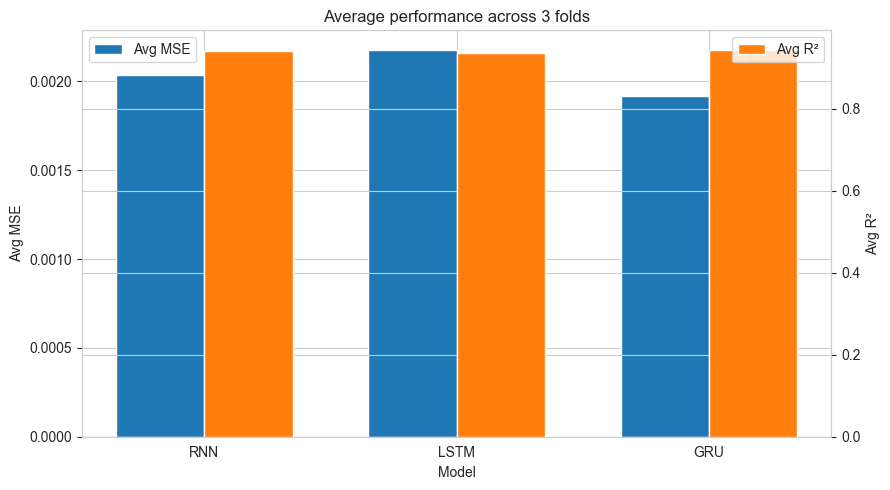

/var/folders/qy/7jvf7f8x5g1bdw0l864hm93w0000gn/T/ipykernel_68843/1216403004.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([results[m]["mse"] for m in models], labels=models)
/var/folders/qy/7jvf7f8x5g1bdw0l864hm93w0000gn/T/ipykernel_68843/1216403004.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([results[m]["r2"]  for m in models], labels=models)
/var/folders/qy/7jvf7f8x5g1bdw0l864hm93w0000gn/T/ipykernel_68843/1216403004.py:38: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout(); plt.show()
/opt/anaconda3/envs/env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.

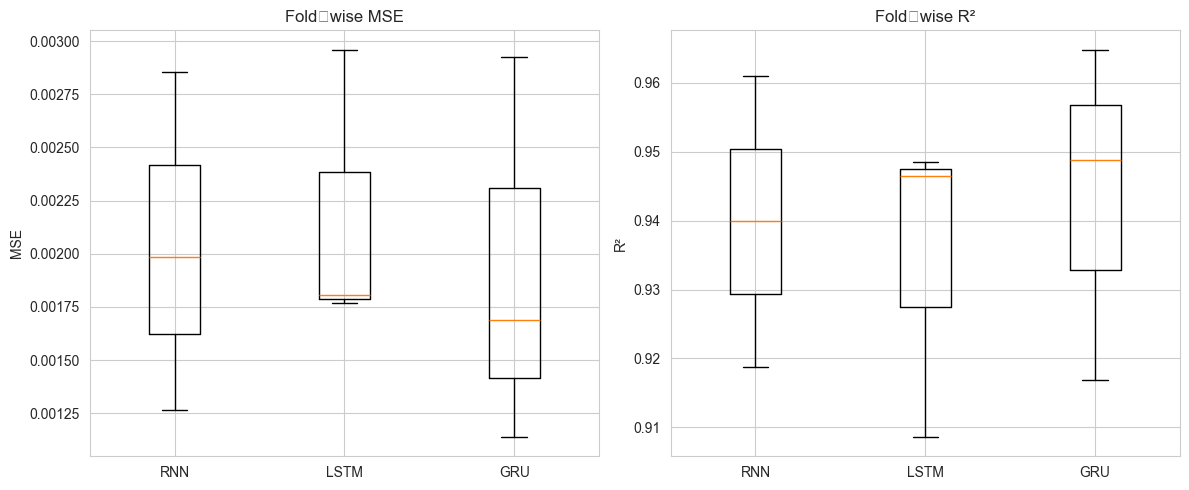

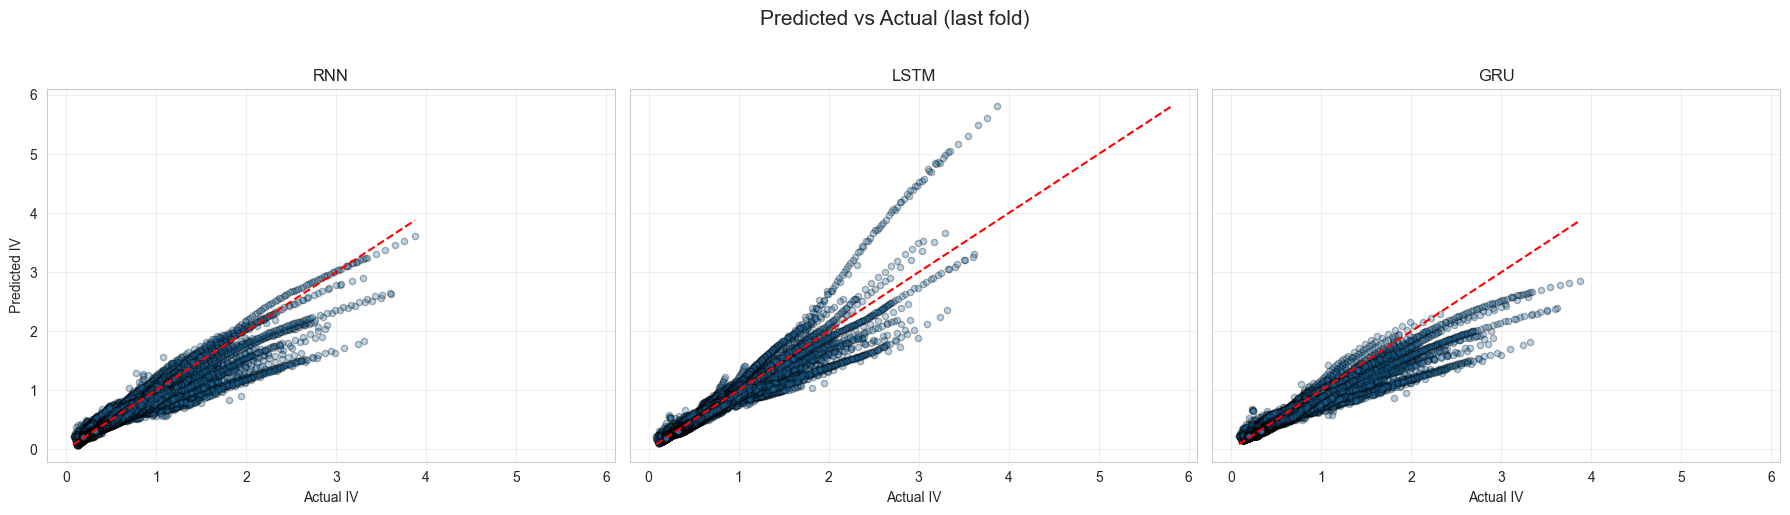

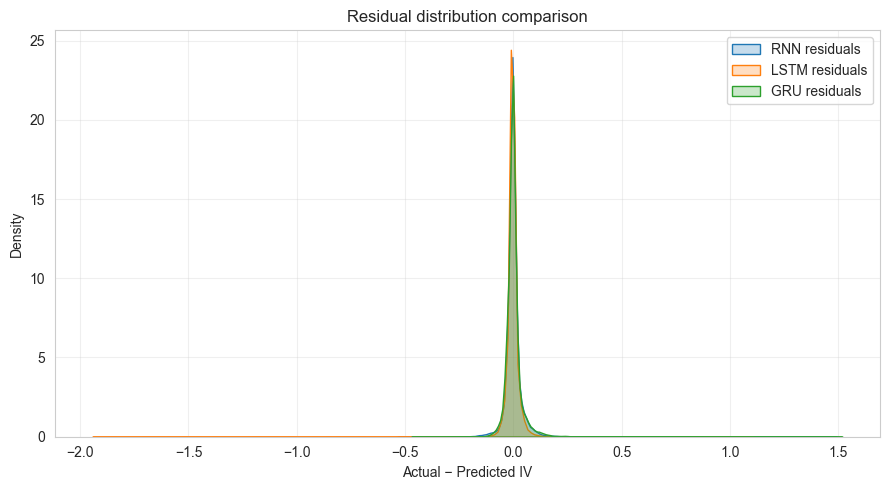

In [ ]:
# ------------------------------------------------------------------
# Comparative visualizations for RNN, LSTM, and GRU results
# ------------------------------------------------------------------
def visualize_results(results: dict) -> None:
    """
    Generate performance comparison plots (average scores,
    fold-wise distributions, predictions vs actuals, residuals)
    based on cross-validation results.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    sns.set_style("whitegrid")
    models = list(results.keys())

    # --- Average MSE and R² for each model ---
    avg_mse = [np.mean(results[m]["mse"]) for m in models]
    avg_r2  = [np.mean(results[m]["r2"]) for m in models]

    fig, ax1 = plt.subplots(figsize=(9,5))
    ax2 = ax1.twinx()
    x = np.arange(len(models))
    width = 0.35

    ax1.bar(x - width/2, avg_mse, width, label="Avg MSE", color="skyblue")
    ax2.bar(x + width/2, avg_r2, width, label="Avg R²", color="salmon")

    ax1.set_xlabel("Model")
    ax1.set_ylabel("Average MSE")
    ax2.set_ylabel("Average R²")
    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.set_title("Average Performance Across 3 Folds")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    # --- Boxplots for fold-wise metrics ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].boxplot([results[m]["mse"] for m in models], labels=models)
    axes[0].set_title("Fold-wise MSE Distribution")
    axes[0].set_ylabel("MSE")

    axes[1].boxplot([results[m]["r2"] for m in models], labels=models)
    axes[1].set_title("Fold-wise R² Distribution")
    axes[1].set_ylabel("R²")

    plt.tight_layout()
    plt.show()

    # --- Scatter plots of Predicted vs Actual (last fold) ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
    for ax, m in zip(axes, models):
        y_true, y_pred = results[m]["y_true"], results[m]["y_pred"]
        ax.scatter(y_true, y_pred, alpha=0.3, edgecolor="k", s=20)
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        ax.plot([min_val, max_val], [min_val, max_val], "r--")
        ax.set_title(f"{m}")
        ax.set_xlabel("Actual IV")
        ax.grid(alpha=0.3)
    axes[0].set_ylabel("Predicted IV")
    fig.suptitle("Predicted vs Actual (Final Fold)", y=1.02, fontsize=15)
    plt.tight_layout()
    plt.show()

    # --- Residual distributions ---
    plt.figure(figsize=(9, 5))
    for m in models:
        residuals = results[m]["y_true"] - results[m]["y_pred"]
        sns.kdeplot(residuals, fill=True, label=f"{m} residuals")
    plt.title("Residual Distribution Comparison")
    plt.xlabel("Residual (Actual - Predicted)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

visualize_results(results)